In [303]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import scipy
import math

from plotly.subplots import make_subplots

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from itertools import product

%matplotlib inline

### <font color='157699'> **Importar Datos** </font>
---

In [304]:
# Lectura de archivo csv
df_original = pd.read_csv("https://raw.githubusercontent.com/Leostark95/Analitica_II_Proyecto_1/main/data/ecommerce-data.csv", sep=",")

# Obtener los 10 primeros registros
df_original.head(10)

,Reviews,Reviews_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Purchase
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,False,False
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2,2,3,Returning_Visitor,False,False
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,False,False


### <font color='157699'> **Transformación de Variables** </font>
---

In [305]:
df_original[['Weekend', 'Purchase']] = df_original[['Weekend', 'Purchase']].astype(int)
df_original[['OperatingSystems','Browser',
             'Region', 'TrafficType', 'VisitorType']] = df_original[['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']].astype(str)

In [306]:
# Variables numéricas

df_nums = df_original.select_dtypes(include=['int64', 'int32', 'float64'])

In [307]:
# Variables numéricas escaladas

scaler = MinMaxScaler()
df_nums_scaled = pd.DataFrame(scaler.fit_transform(df_nums), columns=df_nums.columns)

In [308]:
# Variables categóricas

df_cats = df_original.select_dtypes(include=['object'])

In [309]:
# Variables categóricas dummizadas

df_cats_dummies = pd.get_dummies(df_cats)

### <font color='157699'> **Dataframes** </font>
---

In [310]:
# df concatenado variables numéricas y dummizadas

df = pd.concat([df_nums, df_cats_dummies], axis=1)

In [311]:
# df_1 concatenado variables escaladas y dummizadas

df_final = pd.concat([df_nums_scaled, df_cats_dummies], axis=1)

---

In [312]:
X = df_final.drop('Purchase', axis=1)
y = df_final['Purchase']

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Tamaño del conjunto de entrenamiento: ', X_train.shape)
print('Tamaño del conjunto de validación: ', X_test.shape)

Tamaño del conjunto de entrenamiento:  (9864, 74)
Tamaño del conjunto de validación:  (2466, 74)


---

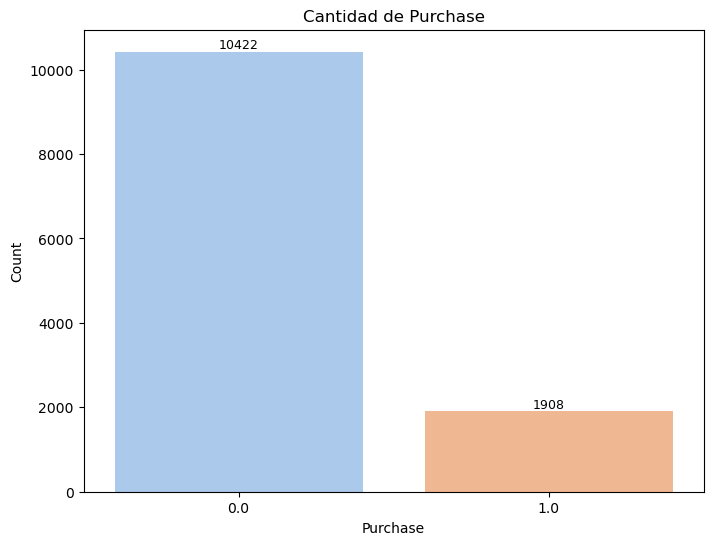

In [314]:
# Conteo de la varibale objetivo Purchase
conteo_purchase = df_final['Purchase'].value_counts()

# Colores personalizados para las barras
colores = sns.color_palette('pastel', len(conteo_purchase))

# Crear el gráfico de barras con los mismos colores
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=conteo_purchase.index, y=conteo_purchase.values, palette=colores)

# Añadir etiquetas y título
plt.xlabel('Purchase')
plt.ylabel('Count')
plt.title('Cantidad de Purchase')

# Añadir etiquetas a las barras
for i, v in enumerate(conteo_purchase.values):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=9)

# Mostrar el gráfico
plt.show()

# <font color='157699'> **Modelo Base** </font>
---

In [315]:
# Entrenamiento del modelo
modelo = LogisticRegression(max_iter=10000)

# Ajustar el modelo a los datos
modelo.fit(X_train, y_train)

# Desempeño en el entrenamiento
y_train_pred = modelo.predict(X_train)
print('Exactitud en el entrenamiento: %.3f'  %accuracy_score(y_train, y_train_pred))

Exactitud en el entrenamiento: 0.881


In [316]:
y_pred = modelo.predict(X_test)

# Exactitud en el conjunto de validación
print('Exactitud en la validacion: %.3f'  %accuracy_score(y_test, y_pred))

Exactitud en la validacion: 0.864


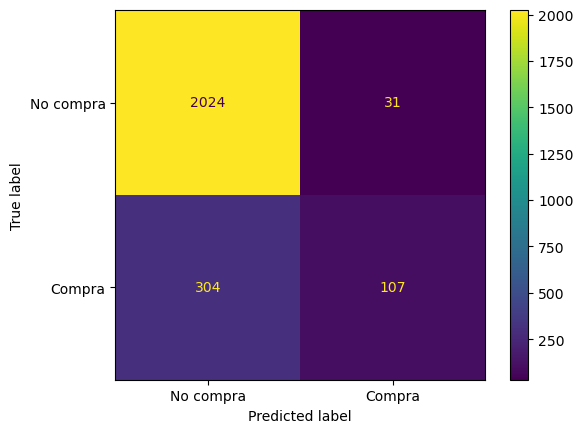

In [317]:
mc = confusion_matrix(y_test, y_pred)
mc_display = ConfusionMatrixDisplay(confusion_matrix = mc, display_labels=['No compra', 'Compra'])
mc_display.plot()
plt.show()

In [318]:
# Desempeño en el entrenamiento
y_train_pred = modelo.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
reporte_train = classification_report(y_train, y_train_pred)

print("Reporte de clasificación para el conjunto de entrenamiento:")
print(reporte_train)
print("Precisión (accuracy) en el conjunto de entrenamiento:", accuracy_train)

# Desempeño en el conjunto de prueba
y_pred = modelo.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
reporte_test = classification_report(y_test, y_pred)

print("\nReporte de clasificación para el conjunto de prueba:")
print(reporte_test)
print("Precisión (accuracy) en el conjunto de prueba:", accuracy_test)


Reporte de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.93      8367
         1.0       0.80      0.29      0.42      1497

    accuracy                           0.88      9864
   macro avg       0.84      0.64      0.68      9864
weighted avg       0.87      0.88      0.86      9864

Precisión (accuracy) en el conjunto de entrenamiento: 0.8806772100567721

Reporte de clasificación para el conjunto de prueba:
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92      2055
         1.0       0.78      0.26      0.39       411

    accuracy                           0.86      2466
   macro avg       0.82      0.62      0.66      2466
weighted avg       0.85      0.86      0.83      2466

Precisión (accuracy) en el conjunto de prueba: 0.8641524736415247


In [319]:
y_pred_proba = modelo.predict_proba(X_test)[:, 1]

# Calcular el AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC del modelo:", auc_score)

AUC del modelo: 0.8693401057298975


### <font color='157699'> **Con Balanceo de Clases** </font>
---

In [320]:
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

# Entrenamiento del modelo
modelo_1 = LogisticRegression(class_weight = "balanced", random_state=142, max_iter=10000)

# Ajustar el modelo a los datos
modelo_1.fit(X_train_1, y_train)

# Desempeño en el entrenamiento
y_train_pred_1 = modelo_1.predict(X_train_1)

print('Exactitud en el entrenamiento: %.3f'  %accuracy_score(y_train, y_train_pred_1))

Exactitud en el entrenamiento: 0.813


In [321]:
y_pred_1 = modelo_1.predict(X_test_1)

# Exactitud en el conjunto de validación
print('Exactitud en el validacion: %.3f'  %accuracy_score(y_test, y_pred_1))

Exactitud en el validacion: 0.819


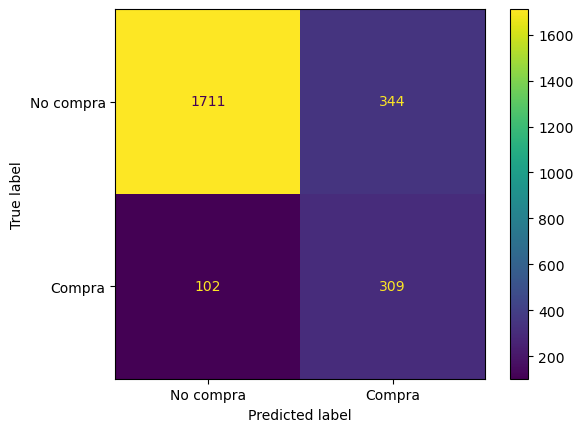

In [322]:
mc_1= confusion_matrix(y_test, y_pred_1)
mc_display_1 = ConfusionMatrixDisplay(confusion_matrix = mc_1, display_labels=['No compra', 'Compra'])
mc_display_1.plot()
plt.show()

In [323]:
from sklearn.metrics import classification_report, accuracy_score

y_train_pred_1 = modelo_1.predict(X_train_1)
accuracy_train_1 = accuracy_score(y_train, y_train_pred_1)
reporte_train_1 = classification_report(y_train, y_train_pred_1)

print("Reporte de clasificación para el conjunto de entrenamiento:")
print(reporte_train_1)
print("Precisión (accuracy) en el conjunto de entrenamiento:", accuracy_train_1)

y_pred_1 = modelo_1.predict(X_test_1)
accuracy_test_1 = accuracy_score(y_test, y_pred_1)
reporte_test_1 = classification_report(y_test, y_pred_1)

print("\nReporte de clasificación para el conjunto de prueba:")
print(reporte_test_1)
print("Precisión (accuracy) en el conjunto de prueba:", accuracy_test_1)


Reporte de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88      8367
         1.0       0.44      0.79      0.56      1497

    accuracy                           0.81      9864
   macro avg       0.70      0.80      0.72      9864
weighted avg       0.88      0.81      0.83      9864

Precisión (accuracy) en el conjunto de entrenamiento: 0.8132603406326034

Reporte de clasificación para el conjunto de prueba:
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88      2055
         1.0       0.47      0.75      0.58       411

    accuracy                           0.82      2466
   macro avg       0.71      0.79      0.73      2466
weighted avg       0.87      0.82      0.83      2466

Precisión (accuracy) en el conjunto de prueba: 0.819140308191403


In [324]:
from sklearn.metrics import roc_auc_score

y_pred_proba_1 = modelo_1.predict_proba(X_test_1)[:, 1]

# Calcular el AUC
auc_score_1 = roc_auc_score(y_test, y_pred_proba_1)

print("AUC del modelo:", auc_score_1)


AUC del modelo: 0.8808804115533296


# <font color='056938'> **Selección de Características** </font>
---

### <font color='157699'> **Con Método Wrapper (RFE)** </font>
---

In [325]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Función recursiva de selección de características
def recursive_feature_selection(X,y,model,k):
  rfe = RFE(model, n_features_to_select=k, step=1)
  fit = rfe.fit(X, y)
  X_new = fit.support_
  print("Num Features: %s" % (fit.n_features_))
  print("Selected Features: %s" % (fit.support_))
  print("Feature Ranking: %s" % (fit.ranking_))

  return X_new

In [326]:
# Establecer Estimador
model = LogisticRegression(max_iter=300) # como máximo va a correr 300 veces sobre los datos de entrenamiento para tratar de ajustarse a ellos

# Obtener columnas seleciconadas - (3 caracteristicas)
X_new = recursive_feature_selection(X_train, y_train, model, 30)

# Nuevo conjunto de datos
X_train_wrap = X_train.iloc[:,X_new]
X_test_wrap = X_test.iloc[:,X_new]
X_train_wrap.head()

Num Features: 30
Selected Features: [False False  True False  True  True  True  True  True  True False  True
 False  True  True False False False  True  True  True False False  True
 False False False  True  True False False False  True  True False  True
 False False False  True False False False False False False False False
 False False False False False  True False  True False  True  True False
  True  True False  True  True False False False False  True  True False
 False False]
Feature Ranking: [ 9 45  1 32  1  1  1  1  1  1 29  1  8  1  1 15  7 23  1  1  1 37 28  1
 33 26 27  1  1 16 34 24  1  1 18  1 19 41  6  1 17 36 22 10 43 42 11 20
 35 21  5 38  3  1 40  1 14  1  1 44  1  1 25  1  1 39 13 12  2  1  1  4
 30 31]


,Informational,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month_Aug,Month_Feb,Month_Jul,...,TrafficType_11,TrafficType_13,TrafficType_15,TrafficType_16,TrafficType_18,TrafficType_19,TrafficType_20,TrafficType_3,TrafficType_8,TrafficType_9
1785,0.000000,0.009929,0.001485,0.071429,0.309524,0.000000,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10407,0.000000,0.114894,0.022539,0.012346,0.069665,0.007656,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
286,0.000000,0.001418,0.000000,1.000000,1.000000,0.000000,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6520,0.166667,0.007092,0.001166,0.000000,0.090909,0.023017,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12251,0.041667,0.012766,0.004361,0.200000,0.208333,0.000000,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### <font color='157699'> **Con Método Integrado (L1)** </font>
---

In [327]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import numpy as np

# Selector de variables con Lasso
sel_ = SelectFromModel(Lasso(alpha=0.001), max_features=30)
sel_.fit(X_train, y_train)
print(sel_.estimator_.coef_)

#Obtener variables seleccionadas
X_new_1 = sel_.get_support()

X_train_intg = X_train.iloc[:,X_new_1]
X_test_intg = X_test.iloc[:,X_new_1]
X_train_intg.head()

[ 3.73205870e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.47015278e-01  0.00000000e+00  0.00000000e+00 -1.27725927e-01
  2.87395678e+00 -1.54520370e-02  3.23298509e-03  0.00000000e+00
 -2.77186315e-02 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -2.50650817e-02 -1.83952750e-02  8.00500908e-02  1.50831240e-02
  0.00000000e+00  0.00000000e+00  7.67111782e-03 -1.70418058e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  6.98712544e-03  9.04300491e-03
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -7.90803882e-03
  7.91458354e-03  0.00000000e+00 -0.00000000e+00 -3.19905785e-02
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000

,Reviews,ProductRelated,ExitRates,PageValues,SpecialDay,Weekend,Month_Dec,Month_Mar,Month_May,Month_Nov,...,OperatingSystems_3,Region_1,Region_2,TrafficType_1,TrafficType_10,TrafficType_13,TrafficType_2,TrafficType_3,TrafficType_8,VisitorType_New_Visitor
1785,0.000000,0.009929,0.309524,0.000000,0.0,0.0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
10407,0.074074,0.114894,0.069665,0.007656,0.0,0.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
286,0.000000,0.001418,1.000000,0.000000,0.0,0.0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
6520,0.185185,0.007092,0.090909,0.023017,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
12251,0.000000,0.012766,0.208333,0.000000,0.0,1.0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,1


---

In [328]:
df_log = df_final.copy()

In [329]:
# Eliminar columnas especificadas
df_log.drop(['Reviews_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'BounceRates'], axis=1, inplace=True)

---

# <font color='056938'> **1. Regresión Logística** </font>
---

### <font color='157699'> **1.1. Modelo con Submuestreo** </font>
---

In [330]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler

In [331]:
# Dividir los datos en características (X) y variable objetivo (y)
X = df_log.drop('Purchase', axis=1)
y = df_log['Purchase']

In [332]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Tamaño del conjunto de entrenamiento: ', X_train.shape)
print('Tamaño del conjunto de validación: ', X_test.shape)

Tamaño del conjunto de entrenamiento:  (9864, 70)
Tamaño del conjunto de validación:  (2466, 70)


In [333]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Aplicar submuestreo para igualar el número de muestras de ambas clases
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Original dataset shape
print("Original dataset shape:", Counter(y))
# Nuevo dataset shape después del submuestreo
print("Resampled dataset shape:", Counter(y_rus))

Original dataset shape: Counter({0.0: 10422, 1.0: 1908})
Resampled dataset shape: Counter({0.0: 1497, 1.0: 1497})


In [334]:
from sklearn.metrics import f1_score, recall_score

# Crear modelo de regresión logística
log_reg_sub = LogisticRegression(max_iter=1000, random_state=42)

# Entrenar modelo
log_reg_sub.fit(X_rus, y_rus)

# Predecir en el conjunto de prueba
y_train_pred_sub = log_reg_sub.predict(X_train)

In [335]:
y_pred_sub = log_reg_sub.predict(X_test)

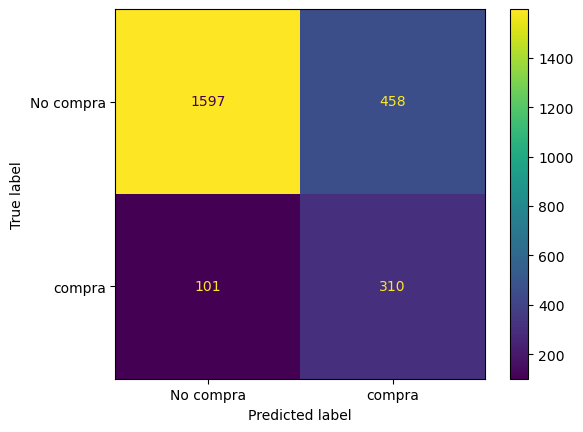

In [336]:
# Matriz de confusión para modelo con submuestreo

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

mc_sub = confusion_matrix(y_test, y_pred_sub)

mc_sub_display = ConfusionMatrixDisplay(confusion_matrix = mc_sub, display_labels = ['No compra', 'compra'])
mc_sub_display.plot()
plt.show()

In [337]:
# Métricas de desempeño

print ("Train - Accuracy :", metrics.accuracy_score(y_train, log_reg_sub.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, log_reg_sub.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, log_reg_sub.predict(X_test)))
print ("Test - classification report :", metrics.classification_report(y_test, log_reg_sub.predict(X_test), digits=4))

Train - Accuracy : 0.769566098945661
Train - classification report:
               precision    recall  f1-score   support

         0.0     0.9549    0.7644    0.8491      8367
         1.0     0.3774    0.7983    0.5125      1497

    accuracy                         0.7696      9864
   macro avg     0.6662    0.7813    0.6808      9864
weighted avg     0.8673    0.7696    0.7980      9864

Test - Accuracy : 0.7733171127331712
Test - classification report :               precision    recall  f1-score   support

         0.0     0.9405    0.7771    0.8511      2055
         1.0     0.4036    0.7543    0.5259       411

    accuracy                         0.7733      2466
   macro avg     0.6721    0.7657    0.6885      2466
weighted avg     0.8510    0.7733    0.7969      2466



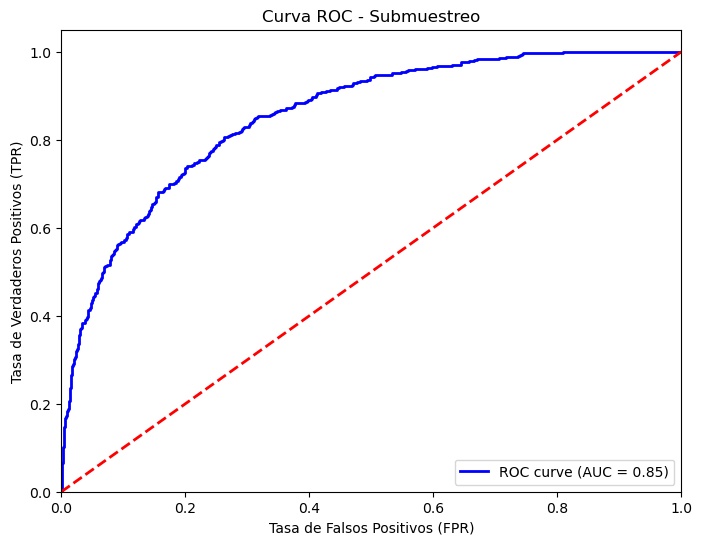

Área bajo la curva (AUC) - Submuestreo: 0.8545071364720787


In [338]:
# Curva ROC

from sklearn.metrics import roc_curve, auc

y_prob_sub = log_reg_sub.predict_proba(X_test)[:, 1] # Obtener probabilidades de predicción para la clase positiva
fpr_sub, tpr_sub, thresholds_sub = roc_curve(y_test, y_prob_sub) # Calcular la curva ROC
auc_sub = auc(fpr_sub, tpr_sub) # Calcular el área bajo la curva (AUC)

plt.figure(figsize=(8, 6))
plt.plot(fpr_sub, tpr_sub, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_sub)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Submuestreo')
plt.legend(loc="lower right")
plt.show()

print("Área bajo la curva (AUC) - Submuestreo:", auc_sub)

### <font color='157699'> **1.2. Modelo con Sobremuestreo** </font>
---

In [339]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Tamaño del conjunto de entrenamiento: ', X_train.shape)
print('Tamaño del conjunto de validación: ', X_test.shape)

Tamaño del conjunto de entrenamiento:  (9864, 70)
Tamaño del conjunto de validación:  (2466, 70)


In [340]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Sobremuestreo de datos
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# Original dataset shape
print("Original dataset shape:", Counter(y))
# Nuevo dataset shape después del submuestreo
print("Resampled dataset shape:", Counter(y_ros))

Original dataset shape: Counter({0.0: 10422, 1.0: 1908})
Resampled dataset shape: Counter({0.0: 8367, 1.0: 8367})


In [341]:
from sklearn.metrics import f1_score, recall_score

# Crear modelo de regresión logística
log_reg_over = LogisticRegression(max_iter=1000, random_state=42)

# Entrenar modelo
log_reg_over.fit(X_ros, y_ros)

# Predecir en el conjunto de prueba
y_train_pred_over = log_reg_over.predict(X_train)

In [342]:
y_pred_over = log_reg_over.predict(X_test)

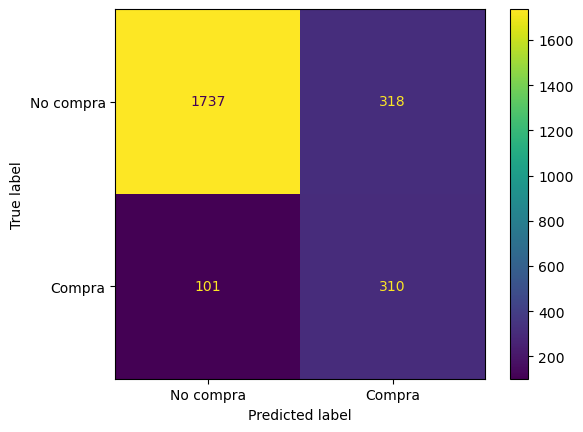

In [343]:
# Matriz de confusión

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

mc_over = confusion_matrix(y_test, y_pred_over)

mc_over_display = ConfusionMatrixDisplay(confusion_matrix = mc_over, display_labels=['No compra', 'Compra'])
mc_over_display.plot()
plt.show()

In [344]:
# Métricas de desempeño

print ("Train - Accuracy :", metrics.accuracy_score(y_train, log_reg_over.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, log_reg_over.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, log_reg_over.predict(X_test)))
print ("Test - classification report :", metrics.classification_report(y_test, log_reg_over.predict(X_test), digits=4))

Train - Accuracy : 0.8233982157339822
Train - classification report:
               precision    recall  f1-score   support

         0.0     0.9547    0.8312    0.8887      8367
         1.0     0.4525    0.7796    0.5726      1497

    accuracy                         0.8234      9864
   macro avg     0.7036    0.8054    0.7307      9864
weighted avg     0.8785    0.8234    0.8407      9864

Test - Accuracy : 0.8300892133008921
Test - classification report :               precision    recall  f1-score   support

         0.0     0.9450    0.8453    0.8924      2055
         1.0     0.4936    0.7543    0.5967       411

    accuracy                         0.8301      2466
   macro avg     0.7193    0.7998    0.7445      2466
weighted avg     0.8698    0.8301    0.8431      2466



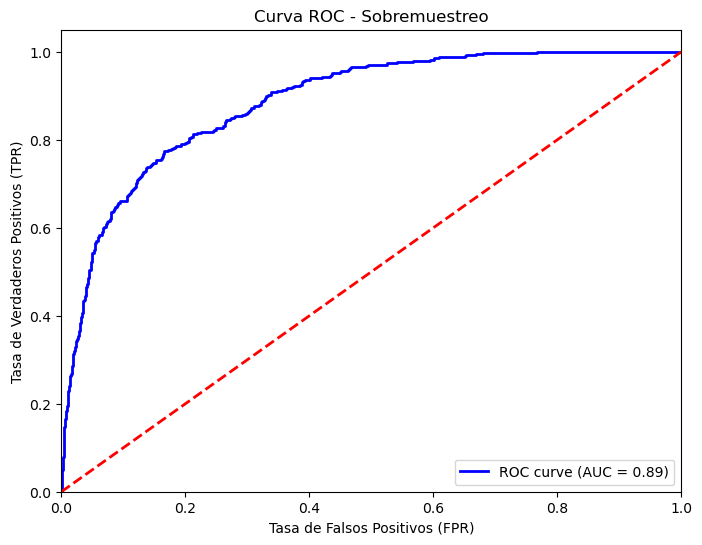

Área bajo la curva (AUC) - Sobremuestreo: 0.88626991315467


In [345]:
# Curva ROC

from sklearn.metrics import roc_curve, auc

# Obtener probabilidades de predicción para la clase positiva
y_prob_over = log_reg_over.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr_over, tpr_over, thresholds_over = roc_curve(y_test, y_prob_over)

# Calcular el área bajo la curva (AUC)
auc_over = auc(fpr_over, tpr_over)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_over, tpr_over, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_over)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Sobremuestreo')
plt.legend(loc="lower right")
plt.show()

# Mostrar el valor de AUC
print("Área bajo la curva (AUC) - Sobremuestreo:", auc_over)

### <font color='157699'> **1.3. Modelo con Wrapper** </font>
---

In [346]:
# Entrenamiento del modelo
modelo_3 = LogisticRegression(class_weight='balanced', random_state=142 )

# Ajustar el modelo a los datos
modelo_3.fit(X_train_wrap, y_train)

# Desempeño en el entrenamiento
y_train_pred_2 = modelo_3.predict(X_train_wrap)

print('Exactitud en el entrenamiento: %.3f'  %accuracy_score(y_train, y_train_pred_2))

Exactitud en el entrenamiento: 0.813


In [347]:
y_pred = modelo_3.predict(X_test_wrap)

# Exactitud en el conjunto de validación
print('Exactitud en la validacion: %.3f'  %accuracy_score(y_test, y_pred))

Exactitud en la validacion: 0.818


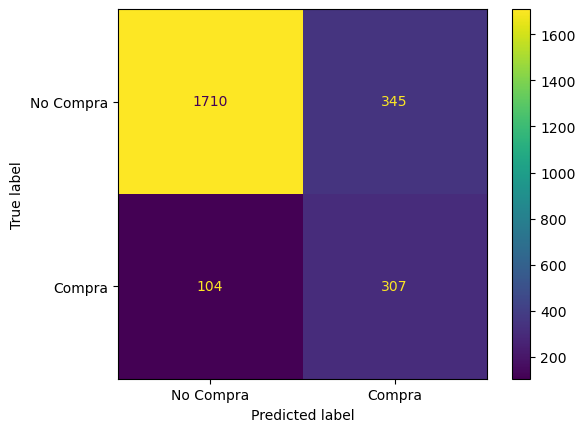

In [348]:
mc = confusion_matrix(y_test, y_pred)
mc_display = ConfusionMatrixDisplay(confusion_matrix = mc, display_labels=['No Compra', 'Compra'])
mc_display.plot()
plt.show()

In [349]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_train_pred = modelo_3.predict(X_train_wrap)
accuracy_train = accuracy_score(y_train, y_train_pred)
reporte_train = classification_report(y_train, y_train_pred)

print("Reporte de clasificación para el conjunto de entrenamiento:")
print(reporte_train)
print("Precisión (accuracy) en el conjunto de entrenamiento:", accuracy_train)

y_pred = modelo_3.predict(X_test_wrap)
accuracy_test = accuracy_score(y_test, y_pred)
reporte_test = classification_report(y_test, y_pred)

print("\nReporte de clasificación para el conjunto de prueba:")
print(reporte_test)
print("Precisión (accuracy) en el conjunto de prueba:", accuracy_test)


Reporte de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88      8367
         1.0       0.44      0.78      0.56      1497

    accuracy                           0.81      9864
   macro avg       0.70      0.80      0.72      9864
weighted avg       0.88      0.81      0.83      9864

Precisión (accuracy) en el conjunto de entrenamiento: 0.8133617193836172

Reporte de clasificación para el conjunto de prueba:
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88      2055
         1.0       0.47      0.75      0.58       411

    accuracy                           0.82      2466
   macro avg       0.71      0.79      0.73      2466
weighted avg       0.86      0.82      0.83      2466

Precisión (accuracy) en el conjunto de prueba: 0.8179237631792377


In [350]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_pred)
print("AUC en el conjunto de prueba:", auc_score)


AUC en el conjunto de prueba: 0.789537712895377


### <font color='157699'> **1.4. Modelo con Integrado** </font>
---

In [351]:
from sklearn.metrics import accuracy_score

# Entrenamiento del modelo
modelo_4 = LogisticRegression(random_state=142, class_weight='balanced')

# Ajustar el modelo a los datos
modelo_4.fit(X_train_intg, y_train)

# Desempeño en el entrenamiento
y_train_pred_2 = modelo_4.predict(X_train_intg)

print('Exactitud en el entrenamiento: %.3f'  %accuracy_score(y_train, y_train_pred_2))

Exactitud en el entrenamiento: 0.816


In [352]:
y_pred = modelo_4.predict(X_test_intg)

# Exactitud en el conjunto de validación
print('Exactitud en la validacion: %.3f'  %accuracy_score(y_test, y_pred))

Exactitud en la validacion: 0.819


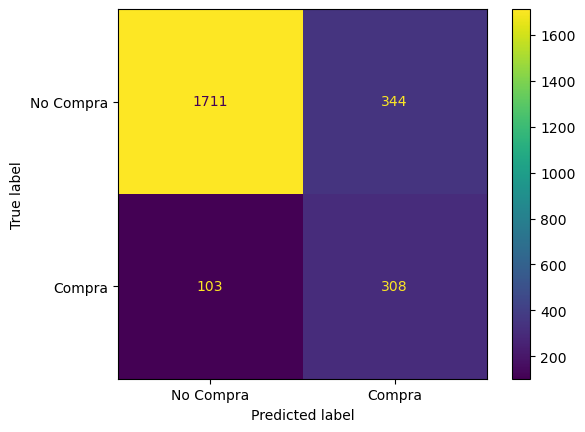

In [353]:
mc = confusion_matrix(y_test, y_pred)
mc_display = ConfusionMatrixDisplay(confusion_matrix = mc, display_labels=['No Compra', 'Compra'])
mc_display.plot()
plt.show()

In [354]:
from sklearn.metrics import classification_report, accuracy_score

y_train_pred = modelo_4.predict(X_train_intg)
accuracy_train = accuracy_score(y_train, y_train_pred)
reporte_train = classification_report(y_train, y_train_pred)

print("Reporte de clasificación para el conjunto de entrenamiento:")
print(reporte_train)
print("Precisión (accuracy) en el conjunto de entrenamiento:", accuracy_train)

y_test_pred = modelo_4.predict(X_test_intg)
accuracy_test = accuracy_score(y_test, y_test_pred)
reporte_test = classification_report(y_test, y_test_pred)

print("\nReporte de clasificación para el conjunto de prueba:")
print(reporte_test)
print("Precisión (accuracy) en el conjunto de prueba:", accuracy_test)

Reporte de clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88      8367
         1.0       0.44      0.78      0.56      1497

    accuracy                           0.82      9864
   macro avg       0.70      0.80      0.72      9864
weighted avg       0.88      0.82      0.83      9864

Precisión (accuracy) en el conjunto de entrenamiento: 0.8158961881589619

Reporte de clasificación para el conjunto de prueba:
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88      2055
         1.0       0.47      0.75      0.58       411

    accuracy                           0.82      2466
   macro avg       0.71      0.79      0.73      2466
weighted avg       0.86      0.82      0.83      2466

Precisión (accuracy) en el conjunto de prueba: 0.818734793187348


In [355]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_pred)
print("AUC en el conjunto de prueba:", auc_score)


AUC en el conjunto de prueba: 0.7909975669099757


### <font color='157699'> **1.5. Modelo con Cross Validation** </font>
---

In [356]:
from sklearn.model_selection import  cross_validate
from sklearn.linear_model import LogisticRegression

def cross_validation(model, _X, _y, _cv=5, scoring='f1'): # 5 es el número de paqueticos
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True) # importante

      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [357]:
# Modelo de regresión logística
modelo_5 = LogisticRegression(class_weight="balanced", random_state=0, max_iter=300)
# Evaluación del modelo
modelo_5_result = cross_validation(modelo_5, X, y, 5)

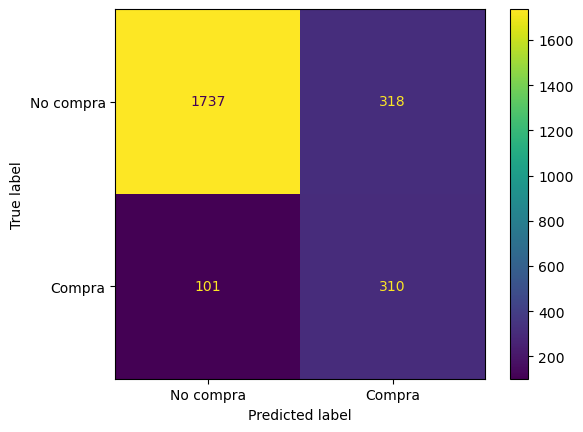

In [358]:
mc_cv = confusion_matrix(y_test, y_pred_over)

mc_cv_display = ConfusionMatrixDisplay(confusion_matrix = mc_cv, display_labels=['No compra', 'Compra'])
mc_cv_display.plot()
plt.show()

In [359]:
print("Mean Training F1 Score: ", modelo_5_result['Mean Training F1 Score'],
      "\nMean Validation F1 Score: ", modelo_5_result['Mean Validation F1 Score'])

Mean Training F1 Score:  0.5693980732909097 
Mean Validation F1 Score:  0.5117891023165722


In [360]:
# Otra alternativa utilizando LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV

# Definición de modelo y ajuste a todos los datos
log_recall = LogisticRegressionCV(cv=10, random_state=0, class_weight="balanced", scoring='recall', max_iter=300).fit(X, y)

print("Score: ", log_recall.score(X, y))

Score:  0.7777777777777778


# <font color='056938'> **2. Métodos de Ensamble** </font>
---

## <font color='157699'> **2.1. Random Forest** </font>
---

### <font color='157699'> **2.1.1. Random Forest con Wrapper** </font>

In [412]:
X_train_ranfor_wrap = X_train_wrap
X_test_ranfor_wrap = X_test_wrap

In [362]:
from sklearn.ensemble import RandomForestClassifier
# Entrenamiento del modelo
# ==============================================================================
ranfor = RandomForestClassifier(
            n_estimators = 150,
            criterion    = 'gini',
            n_jobs       = -1,
            random_state = 123
         )
ranfor.fit(X_train_ranfor_wrap, y_train)

RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=123)

In [363]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor.predict(X_train_ranfor_wrap)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor.predict(X_train_ranfor_wrap)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor.predict(X_test_ranfor_wrap)))
print ("Test - classification report :", metrics.classification_report(y_test, ranfor.predict(X_test_ranfor_wrap)))

Train - Accuracy : 1.0
Train - classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8367
         1.0       1.00      1.00      1.00      1497

    accuracy                           1.00      9864
   macro avg       1.00      1.00      1.00      9864
weighted avg       1.00      1.00      1.00      9864

Test - Accuracy : 0.894566098945661
Test - classification report :               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2055
         1.0       0.74      0.56      0.64       411

    accuracy                           0.89      2466
   macro avg       0.83      0.76      0.79      2466
weighted avg       0.89      0.89      0.89      2466



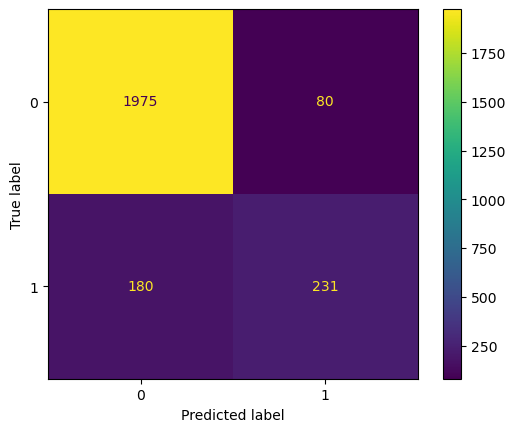

In [364]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, ranfor.predict(X_test_ranfor_wrap))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

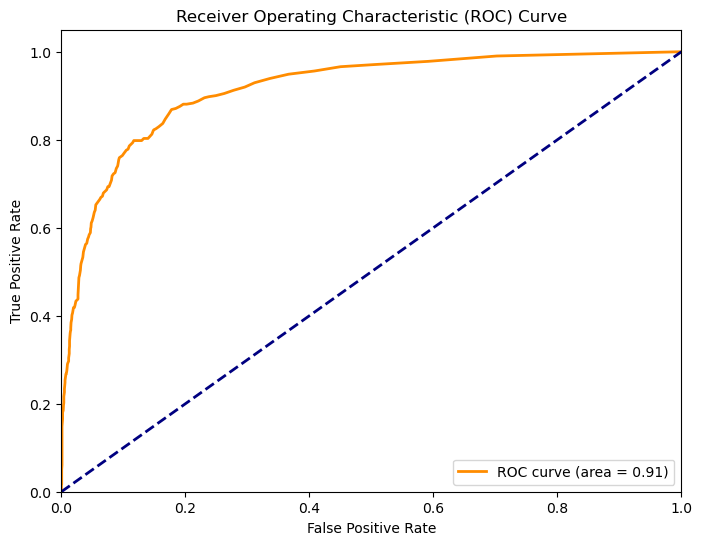

Valor del AUC: 0.9141373778275051


In [365]:
# Predicciones de probabilidad en el conjunto de prueba
y_pred_proba = ranfor.predict_proba(X_test_ranfor_wrap)[:,1]

# Calcula la tasa de falsos positivos (fpr), la tasa de verdaderos positivos (tpr)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calcula el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Valor del AUC
print("Valor del AUC:", roc_auc)


### <font color='157699'> **2.1.2. Random Forest con Integrado** </font>

In [366]:
X_train_ranfor_intg = X_train_intg
X_test_ranfor_intg = X_test_intg

In [367]:
from sklearn.ensemble import RandomForestClassifier

ranfor = RandomForestClassifier(
            n_estimators = 150,
            criterion    = 'gini',
            #max_depth    = 5,
            #max_leaf_nodes = 10,
            n_jobs       = -1,
            random_state = 123
         )
ranfor.fit(X_train_ranfor_intg, y_train)

RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=123)

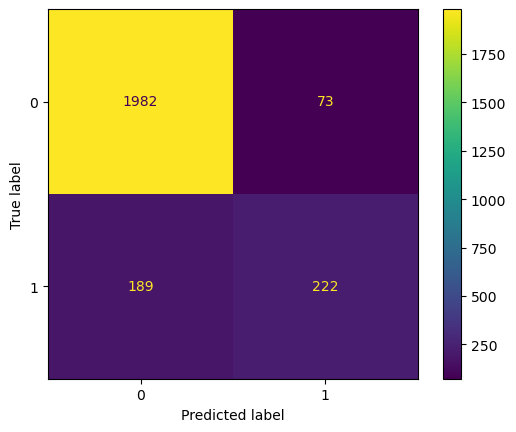

In [368]:
cm = confusion_matrix(y_test, ranfor.predict(X_test_ranfor_intg))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

In [369]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor.predict(X_train_ranfor_intg)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor.predict(X_train_ranfor_intg)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor.predict(X_test_ranfor_intg)))
print ("Test - classification report :", metrics.classification_report(y_test, ranfor.predict(X_test_ranfor_intg)))

Train - Accuracy : 0.9998986212489862
Train - classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8367
         1.0       1.00      1.00      1.00      1497

    accuracy                           1.00      9864
   macro avg       1.00      1.00      1.00      9864
weighted avg       1.00      1.00      1.00      9864

Test - Accuracy : 0.8937550689375506
Test - classification report :               precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      2055
         1.0       0.75      0.54      0.63       411

    accuracy                           0.89      2466
   macro avg       0.83      0.75      0.78      2466
weighted avg       0.89      0.89      0.89      2466



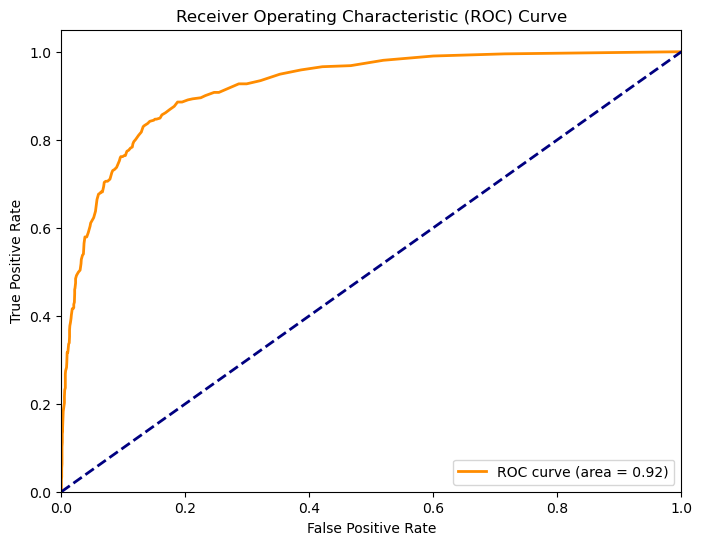

Valor del AUC: 0.9204030286346873


In [370]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = ranfor.predict_proba(X_test_ranfor_intg)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Valor del AUC:", roc_auc)


### <font color='157699'> **2.1.3. Random Forest con Tunning de Hiperparámetros** </font>

#### Integrado

In [371]:
# Importar librerias adicionales
# ==============================================================================
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pprint

In [372]:
## Definir cuadricula de búsqueda
# =================================================
parameters = {
    'max_depth': [1, 5, 10],
    'max_features': [0.4, 0.6, 0.8],
    'max_leaf_nodes': [12, 14, 16],
    'min_samples_leaf': [8 ,10, 15],
    'n_estimators': [50, 100, 150]
}

In [373]:
# Búsqueda en Cuadricula
# ==============================================================================

# Modelo para tunning
ranfor = RandomForestClassifier(
    criterion = 'gini',
    n_jobs = -1,
    class_weight='balanced',
    random_state= 123
)

grid_search = GridSearchCV(ranfor, parameters, scoring = 'roc_auc', cv=5, n_jobs=-1)

# Iniciamos la busqueda
grid_result = grid_search.fit(X_train_ranfor_intg, y_train)

print('Best Params: ', grid_result.best_params_)
print('Best Score: ', grid_result.best_score_)

Best Params:  {'max_depth': 10, 'max_features': 0.6, 'max_leaf_nodes': 16, 'min_samples_leaf': 8, 'n_estimators': 100}
Best Score:  0.9316157996455988


In [379]:
print('Características usadas en el entrenamiento: ', grid_result.best_estimator_.feature_names_in_)
print('Importancia de las carcaterísticas: ', grid_result.best_estimator_.feature_importances_)

Características usadas en el entrenamiento:  ['Reviews' 'ProductRelated' 'ExitRates' 'PageValues' 'SpecialDay'
 'Weekend' 'Month_Dec' 'Month_Mar' 'Month_May' 'Month_Nov' 'Month_Oct'
 'OperatingSystems_2' 'OperatingSystems_3' 'Region_1' 'Region_2'
 'TrafficType_1' 'TrafficType_10' 'TrafficType_13' 'TrafficType_2'
 'TrafficType_3' 'TrafficType_8' 'VisitorType_New_Visitor']
Importancia de las carcaterísticas:  [2.19104779e-02 4.35825912e-02 6.97084441e-02 7.64153786e-01
 1.52758290e-03 4.26110399e-04 1.01144295e-03 9.90612288e-03
 1.46935790e-02 6.32321992e-02 6.95907599e-04 1.61198431e-04
 4.51717231e-04 2.99775280e-04 1.49794550e-04 6.18207810e-04
 6.74573293e-05 7.55179848e-04 8.33155734e-04 3.92954128e-04
 1.74112827e-03 3.68118691e-03]


In [380]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor_optimo.predict(X_train_ranfor_intg)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor_optimo.predict(X_train_ranfor_intg)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor_optimo.predict(X_test_ranfor_intg)))
print ("Test - classification report :", metrics.classification_report(y_test, ranfor_optimo.predict(X_test_ranfor_intg)))

Train - Accuracy : 0.8606042173560422
Train - classification report:
               precision    recall  f1-score   support

         0.0       0.97      0.86      0.91      8367
         1.0       0.52      0.86      0.65      1497

    accuracy                           0.86      9864
   macro avg       0.75      0.86      0.78      9864
weighted avg       0.90      0.86      0.87      9864

Test - Accuracy : 0.8584752635847527
Test - classification report :               precision    recall  f1-score   support

         0.0       0.97      0.86      0.91      2055
         1.0       0.55      0.85      0.67       411

    accuracy                           0.86      2466
   macro avg       0.76      0.86      0.79      2466
weighted avg       0.90      0.86      0.87      2466



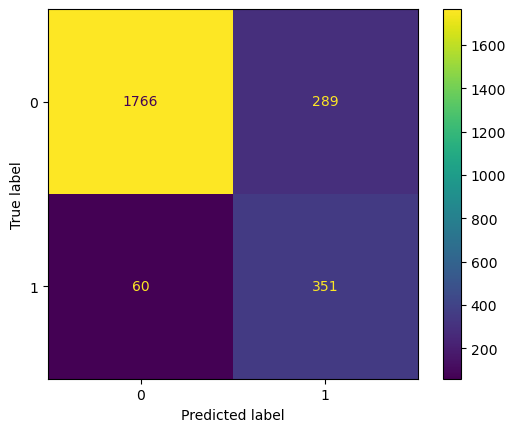

In [ ]:
# Matriz de confusion
cm1= confusion_matrix(y_test, ranfor_optimo.predict(X_test_ranfor_intg))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()

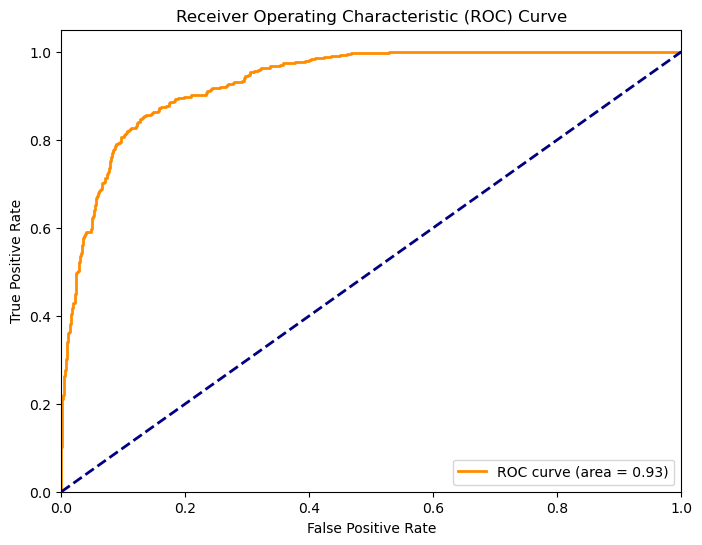

Valor del AUC: 0.9328182996785479


In [411]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ajustar el modelo con los mejores parámetros encontrados
best_model = grid_result.best_estimator_
best_model.fit(X_train_ranfor_intg, y_train)

# Predicciones de probabilidad en el conjunto de prueba
y_pred_proba = best_model.predict_proba(X_test_ranfor_intg)[:, 1]

# Calcular la tasa de falsos positivos (fpr) y la tasa de verdaderos positivos (tpr)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Valor del AUC
print("Valor del AUC:", roc_auc)


#### Wrapper

In [416]:
# Búsqueda en Cuadricula
# ==============================================================================

# Modelo para tunning
ranfor_1 = RandomForestClassifier(
    criterion = 'gini',
    n_jobs = -1,
    class_weight='balanced',
    random_state= 123
)

grid_search = GridSearchCV(ranfor_1, parameters, scoring = 'roc_auc', cv=5, n_jobs=-1)

# Iniciamos la busqueda
grid_result = grid_search.fit(X_train_ranfor_wrap, y_train)

print('Best Params: ', grid_result.best_params_)
print('Best Score: ', grid_result.best_score_)

ValueError: Invalid parameter 'learning_rate' for estimator RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=123). Valid parameters are: ['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

In [413]:
print('Características usadas en el entrenamiento: ', grid_result.best_estimator_.feature_names_in_)
print('Importancia de las carcaterísticas: ', grid_result.best_estimator_.feature_importances_)

Características usadas en el entrenamiento:  ['Reviews' 'ProductRelated' 'ExitRates' 'PageValues' 'SpecialDay'
 'Weekend' 'Month_Dec' 'Month_Mar' 'Month_May' 'Month_Nov' 'Month_Oct'
 'OperatingSystems_2' 'OperatingSystems_3' 'Region_1' 'Region_2'
 'TrafficType_1' 'TrafficType_10' 'TrafficType_13' 'TrafficType_2'
 'TrafficType_3' 'TrafficType_8' 'VisitorType_New_Visitor']
Importancia de las carcaterísticas:  [0.05858229 0.08611233 0.09690413 0.64289582 0.00486077 0.0064793
 0.00381259 0.00467962 0.0070945  0.03665721 0.00182113 0.00310343
 0.00555794 0.00380284 0.00356173 0.00359557 0.00358693 0.00212343
 0.00507222 0.00253583 0.00426841 0.01289198]


In [414]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor_optimo.predict(X_train_ranfor_wrap)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor_optimo.predict(X_train_ranfor_wrap)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor_optimo.predict(X_test_ranfor_wrap)))
print ("Test - classification report :", metrics.classification_report(y_test, ranfor_optimo.predict(X_test_ranfor_wrap)))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- BounceRates
- Browser_12
- Browser_13
- Browser_3
- Browser_7
- ...
Feature names seen at fit time, yet now missing:
- Month_Dec
- Month_Mar
- Month_May
- OperatingSystems_2
- Region_1
- ...


In [ ]:
# Matriz de confusion
cm1= confusion_matrix(y_test, ranfor_optimo.predict(X_test_ranfor_wrap))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# Predicciones de probabilidad en el conjunto de prueba
y_pred_proba = grid_result.predict_proba(X_test_ranfor_wrap)[:, 1]

# Calcular el AUC
auc_score = roc_auc_score(y_test, y_pred_proba)

print("AUC del modelo:", auc_score)


## <font color='157699'> **2.2. XGB Classifier** </font>
---

### <font color='157699'> **2.2.1. XGB con Wrapper** </font>

In [390]:
X_train_XGB_wrap = X_train_wrap
X_test_XGB_wrap = X_test_wrap

In [391]:
#%pip install xgboost
from xgboost import XGBClassifier
# Entrenamiento del modelo: N_ESTIMATORS = 100, LEARNING_RATE = 0.1, , MAX_DEPTH = 4
# ===================================================================================
xgb = XGBClassifier(
    n_estimators = 100,
    learning_rate= 0.1,
    max_depth = 4,
    random_state = 123
)

xgb.fit(X_train_XGB_wrap, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [392]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, xgb.predict(X_train_XGB_wrap)))
print ("Train - classification report:\n", metrics.classification_report(y_train, xgb.predict(X_train_XGB_wrap)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, xgb.predict(X_test_XGB_wrap)))
print ("Test - classification report :", metrics.classification_report(y_test, xgb.predict(X_test_XGB_wrap)))

Train - Accuracy : 0.9226480129764801
Train - classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      8367
         1.0       0.80      0.66      0.72      1497

    accuracy                           0.92      9864
   macro avg       0.87      0.81      0.84      9864
weighted avg       0.92      0.92      0.92      9864

Test - Accuracy : 0.9010543390105434
Test - classification report :               precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      2055
         1.0       0.75      0.61      0.67       411

    accuracy                           0.90      2466
   macro avg       0.84      0.79      0.81      2466
weighted avg       0.90      0.90      0.90      2466



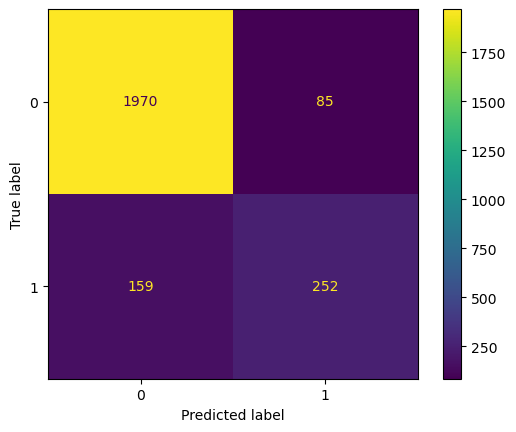

In [393]:
# Matriz de confusión
# ==============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm = confusion_matrix(y_test, xgb.predict(X_test_XGB_wrap))
# Visualización de la matriz de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

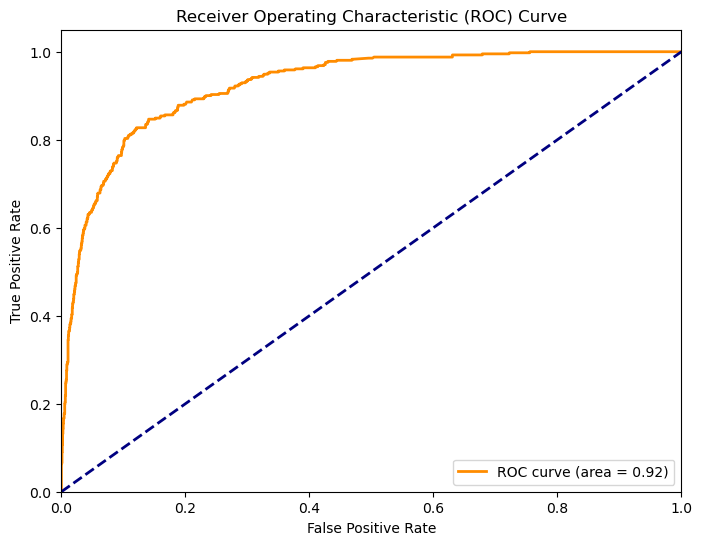

Valor del AUC: 0.9242048057967924


In [394]:
from sklearn.metrics import roc_curve, auc

# Predicciones de probabilidad en el conjunto de prueba
y_pred_proba = xgb.predict_proba(X_test_XGB_wrap)[:,1]

# Calcula la tasa de falsos positivos (fpr), la tasa de verdaderos positivos (tpr)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calcula el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Valor del AUC
print("Valor del AUC:", roc_auc)


### <font color='157699'> **2.2.2. XGB con Integrado** </font>

In [395]:
X_train_XGB_intg = X_train_intg
X_test_XGB_intg = X_test_intg

In [396]:
# Entrenamiento del modelo: N_ESTIMATORS = 100, LEARNING_RATE = 0.1, , MAX_DEPTH = 4
# ===================================================================================
xgb = XGBClassifier(
    n_estimators = 100,
    learning_rate= 0.1,
    max_depth = 4,
    random_state = 123
)

xgb.fit(X_train_XGB_intg, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

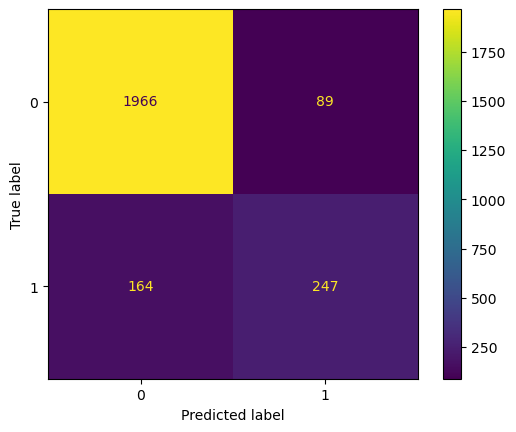

In [397]:
# Matriz de confusión
# ==============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm = confusion_matrix(y_test, xgb.predict(X_test_XGB_intg))
# Visualización de la matriz de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

In [398]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, xgb.predict(X_train_XGB_intg)))
print ("Train - classification report:\n", metrics.classification_report(y_train, xgb.predict(X_train_XGB_intg)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, xgb.predict(X_test_XGB_intg)))
print ("Test - classification report :", metrics.classification_report(y_test, xgb.predict(X_test_XGB_intg)))

Train - Accuracy : 0.9216342254663422
Train - classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      8367
         1.0       0.79      0.66      0.72      1497

    accuracy                           0.92      9864
   macro avg       0.87      0.81      0.84      9864
weighted avg       0.92      0.92      0.92      9864

Test - Accuracy : 0.897404703974047
Test - classification report :               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2055
         1.0       0.74      0.60      0.66       411

    accuracy                           0.90      2466
   macro avg       0.83      0.78      0.80      2466
weighted avg       0.89      0.90      0.89      2466



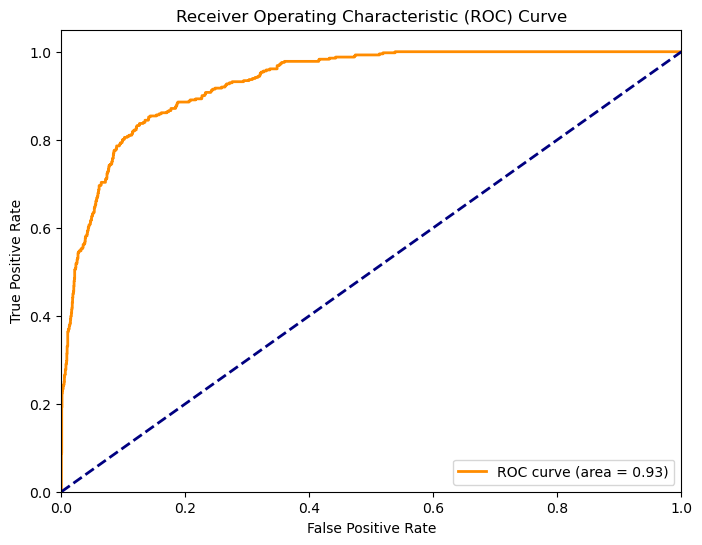

Valor del AUC: 0.930914451133962


In [399]:
from sklearn.metrics import roc_curve, auc

# Predicciones de probabilidad en el conjunto de prueba
y_pred_proba = xgb.predict_proba(X_test_XGB_intg)[:,1]

# Calcula la tasa de falsos positivos (fpr), la tasa de verdaderos positivos (tpr)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calcula el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Valor del AUC
print("Valor del AUC:", roc_auc)


### <font color='157699'> **2.1.3. XGB con Tunning de Hiperparámetros** </font>

#### Integrado

In [400]:
parameters = {
    'n_estimators': [50, 100, 300],
    'max_features': [5, 6, 7],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.03, 0.05],
    'subsample': [0.7, 0.8, 0.9,]}

In [401]:
# Modelo para tunning
XGB = GradientBoostingClassifier(
    random_state= 123
)

grid_search = GridSearchCV(XGB, parameters, scoring = 'roc_auc', cv=5, n_jobs=-1)

# Iniciamos la busqueda
grid_result = grid_search.fit(X_train_XGB_intg, y_train)

print('Best Params: ', grid_result.best_params_)
print('Best Score: ', grid_result.best_score_)

Best Params:  {'learning_rate': 0.03, 'max_depth': 5, 'max_features': 7, 'n_estimators': 300, 'subsample': 0.8}
Best Score:  0.9354015584690382


In [402]:
print('Características usadas en el entrenamiento: ', grid_result.best_estimator_.feature_names_in_)
print('Importancia de las carcaterísticas: ', grid_result.best_estimator_.feature_importances_)

Características usadas en el entrenamiento:  ['Reviews' 'ProductRelated' 'ExitRates' 'PageValues' 'SpecialDay'
 'Weekend' 'Month_Dec' 'Month_Mar' 'Month_May' 'Month_Nov' 'Month_Oct'
 'OperatingSystems_2' 'OperatingSystems_3' 'Region_1' 'Region_2'
 'TrafficType_1' 'TrafficType_10' 'TrafficType_13' 'TrafficType_2'
 'TrafficType_3' 'TrafficType_8' 'VisitorType_New_Visitor']
Importancia de las carcaterísticas:  [0.05671962 0.09098702 0.10342343 0.63267144 0.00447564 0.00610535
 0.00454753 0.00504964 0.00697839 0.03580412 0.00197266 0.0032575
 0.0051698  0.00383074 0.00371931 0.0042649  0.00430639 0.00194654
 0.0055082  0.0029422  0.00437276 0.01194683]


In [404]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, XGB_optimo.predict(X_train_XGB_intg)))
print ("Train - classification report:\n", metrics.classification_report(y_train, XGB_optimo.predict(X_train_XGB_intg)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, XGB_optimo.predict(X_test_XGB_intg)))
print ("Test - classification report :", metrics.classification_report(y_test, XGB_optimo.predict(X_test_XGB_intg)))

Train - Accuracy : 0.9354217356042174
Train - classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      8367
         1.0       0.85      0.69      0.77      1497

    accuracy                           0.94      9864
   macro avg       0.90      0.84      0.86      9864
weighted avg       0.93      0.94      0.93      9864

Test - Accuracy : 0.8961881589618816
Test - classification report :               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2055
         1.0       0.74      0.59      0.65       411

    accuracy                           0.90      2466
   macro avg       0.83      0.77      0.80      2466
weighted avg       0.89      0.90      0.89      2466



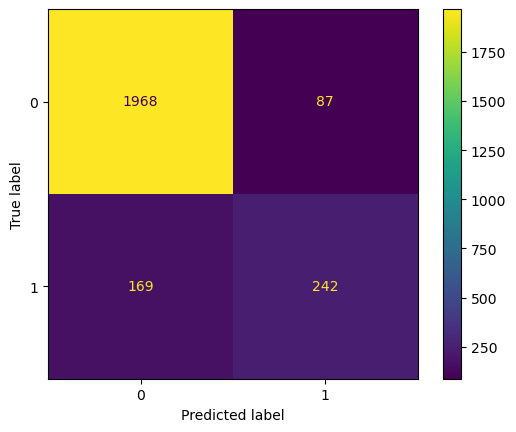

In [405]:
# Matriz de confusion
cm1= confusion_matrix(y_test, XGB_optimo.predict(X_test_XGB_intg))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()

#### Wrapper

In [406]:
# Modelo para tunning
XGB = GradientBoostingClassifier(
    random_state= 123
)

grid_search = GridSearchCV(XGB, parameters, scoring = 'roc_auc', cv=5, n_jobs=-1)

# Iniciamos la busqueda
grid_result = grid_search.fit(X_train_XGB_wrap, y_train)

print('Best Params: ', grid_result.best_params_)
print('Best Score: ', grid_result.best_score_)

Best Params:  {'learning_rate': 0.03, 'max_depth': 5, 'max_features': 7, 'n_estimators': 300, 'subsample': 0.9}
Best Score:  0.9283830440669302


In [407]:
print('Características usadas en el entrenamiento: ', grid_result.best_estimator_.feature_names_in_)
print('Importancia de las carcaterísticas: ', grid_result.best_estimator_.feature_importances_)

Características usadas en el entrenamiento:  ['Informational' 'ProductRelated' 'ProductRelated_Duration' 'BounceRates'
 'ExitRates' 'PageValues' 'SpecialDay' 'Month_Aug' 'Month_Feb' 'Month_Jul'
 'Month_Nov' 'Month_Oct' 'Month_Sep' 'OperatingSystems_3'
 'OperatingSystems_7' 'OperatingSystems_8' 'Browser_12' 'Browser_13'
 'Browser_3' 'Browser_7' 'TrafficType_11' 'TrafficType_13'
 'TrafficType_15' 'TrafficType_16' 'TrafficType_18' 'TrafficType_19'
 'TrafficType_20' 'TrafficType_3' 'TrafficType_8' 'TrafficType_9']
Importancia de las carcaterísticas:  [1.65429507e-02 5.82779129e-02 7.87411961e-02 5.10776669e-02
 8.34578496e-02 6.30654309e-01 4.24556260e-03 1.62020874e-03
 3.72460761e-04 3.86937768e-03 3.81197906e-02 3.21599722e-03
 4.71366091e-03 5.03715892e-03 1.10523939e-03 4.30628643e-04
 1.47874073e-03 8.35046072e-04 3.56554929e-04 1.12155807e-03
 1.88156989e-03 2.57457567e-03 3.47165507e-05 1.23278125e-03
 0.00000000e+00 2.84044905e-05 2.15731233e-03 2.73675116e-03
 4.01115411e-03 6.88

In [409]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, XGB_optimo.predict(X_train_XGB_wrap)))
print ("Train - classification report:\n", metrics.classification_report(y_train, XGB_optimo.predict(X_train_XGB_wrap)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, XGB_optimo.predict(X_test_XGB_wrap)))
print ("Test - classification report :", metrics.classification_report(y_test, XGB_optimo.predict(X_test_XGB_wrap)))

Train - Accuracy : 0.931772100567721
Train - classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      8367
         1.0       0.83      0.70      0.76      1497

    accuracy                           0.93      9864
   macro avg       0.89      0.84      0.86      9864
weighted avg       0.93      0.93      0.93      9864

Test - Accuracy : 0.8978102189781022
Test - classification report :               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2055
         1.0       0.75      0.59      0.66       411

    accuracy                           0.90      2466
   macro avg       0.83      0.77      0.80      2466
weighted avg       0.89      0.90      0.89      2466



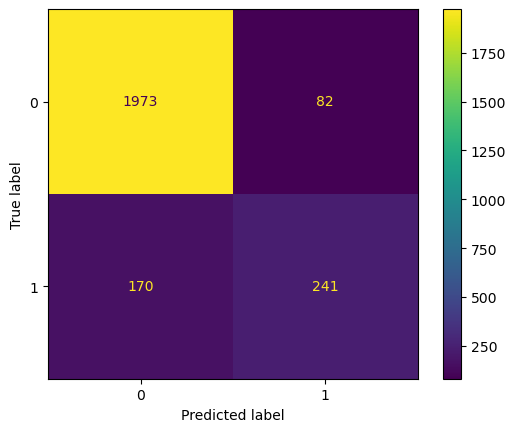

In [410]:
# Matriz de confusion
cm1= confusion_matrix(y_test, XGB_optimo.predict(X_test_XGB_wrap))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()